In [36]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [371]:
#export
from xview2comp.nb_01b import *
from fastai.vision import *
from fastai.utils.collect_env import *

In [40]:
show_install(True)



```text
=== Software === 
python       : 3.7.4
fastai       : 1.0.59
fastprogress : 0.1.21
torch        : 1.2.0
torch cuda   : None / is **Not available** 

=== Hardware === 
No GPUs available 

=== Environment === 
platform     : Darwin-19.0.0-x86_64-i386-64bit
conda env    : fastai_dev
python       : /Users/jack/anaconda3/envs/fastai_dev/bin/python
sys.path     : /Users/jack/git_repos/xview2comp
/Users/jack/anaconda3/envs/fastai_dev/lib/python37.zip
/Users/jack/anaconda3/envs/fastai_dev/lib/python3.7
/Users/jack/anaconda3/envs/fastai_dev/lib/python3.7/lib-dynload

/Users/jack/anaconda3/envs/fastai_dev/lib/python3.7/site-packages
/Users/jack/anaconda3/envs/fastai_dev/lib/python3.7/site-packages/IPython/extensions
/Users/jack/.ipython
../course-v3/nbs/dl2
no supported gpus found on this system
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.



## Load Data

In [6]:
SOURCE = Path('data/train/')
SOURCE.ls()

[PosixPath('data/train/train.tar.gz'),
 PosixPath('data/train/images'),
 PosixPath('data/train/damagemasks'),
 PosixPath('data/train/labels'),
 PosixPath('data/train/binarymasks')]

In [10]:
fnames = get_image_files(SOURCE/'images')
fnames = pre_img_fpaths(fnames)
lbl_names = ListContainer([img2bmask_fpath(o) for o in fnames])

In [13]:
fnames[:3], lbl_names[:3]

([PosixPath('data/train/images/hurricane-harvey_00000015_pre_disaster.png'),
  PosixPath('data/train/images/hurricane-harvey_00000228_pre_disaster.png'),
  PosixPath('data/train/images/hurricane-michael_00000261_pre_disaster.png')],
 [PosixPath('data/train/binarymasks/hurricane-harvey_00000015_pre_disaster.png'),
  PosixPath('data/train/binarymasks/hurricane-harvey_00000228_pre_disaster.png'),
  PosixPath('data/train/binarymasks/hurricane-michael_00000261_pre_disaster.png')])

In [14]:
len(fnames), len(lbl_names)

(2799, 2799)

Note that if your mask is already like small values like 1, 2, 3, etc., instead of 255, etc., don't set `div` to True when loading the masks, as this zeroes everything.  See here:

In [164]:
# step-by-step
fname = lbl_names[-11]
PIL.Image.open(fname)
PIL.Image.open(fname).convert('L')

pil2tensor(PIL.Image.open(fname).convert('L'), np.int32).sum()
#pil2tensor(PIL.Image.open(fname).convert('L'), np.int32).div(255.).sum()


tensor(0)

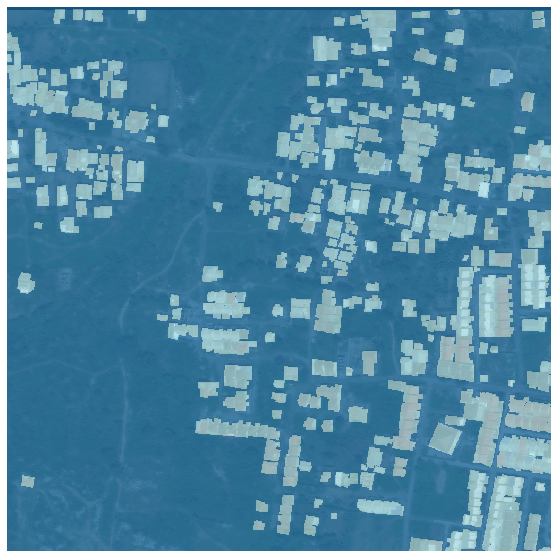

In [125]:
img_f = fnames[-6]
img = open_image(img_f)
mask = open_mask(img2bmask_fpath(img_f))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
img.show(ax=ax)
(mask).show(ax=ax, alpha=.7)


## Make DataBunch

In [217]:
size = 64
bs = 8

In [218]:
codes = np.array(['Empty', 'Building'])

In [219]:
#export
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn)
    
class SegItemListCustom(ImageList):
    _label_cls = SegLabelListCustom

In [220]:
#export
def get_random_val_idx(n, val_pct=.1):
    return np.random.permutation(n)[:int(val_pct * n)]

In [221]:
val_idx = get_random_val_idx(len(fnames))

In [222]:
src = (SegItemListCustom(fnames)
       .split_by_idx(val_idx)
       .label_from_func(img2bmask_fpath, classes=codes))

In [223]:
tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=.3)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

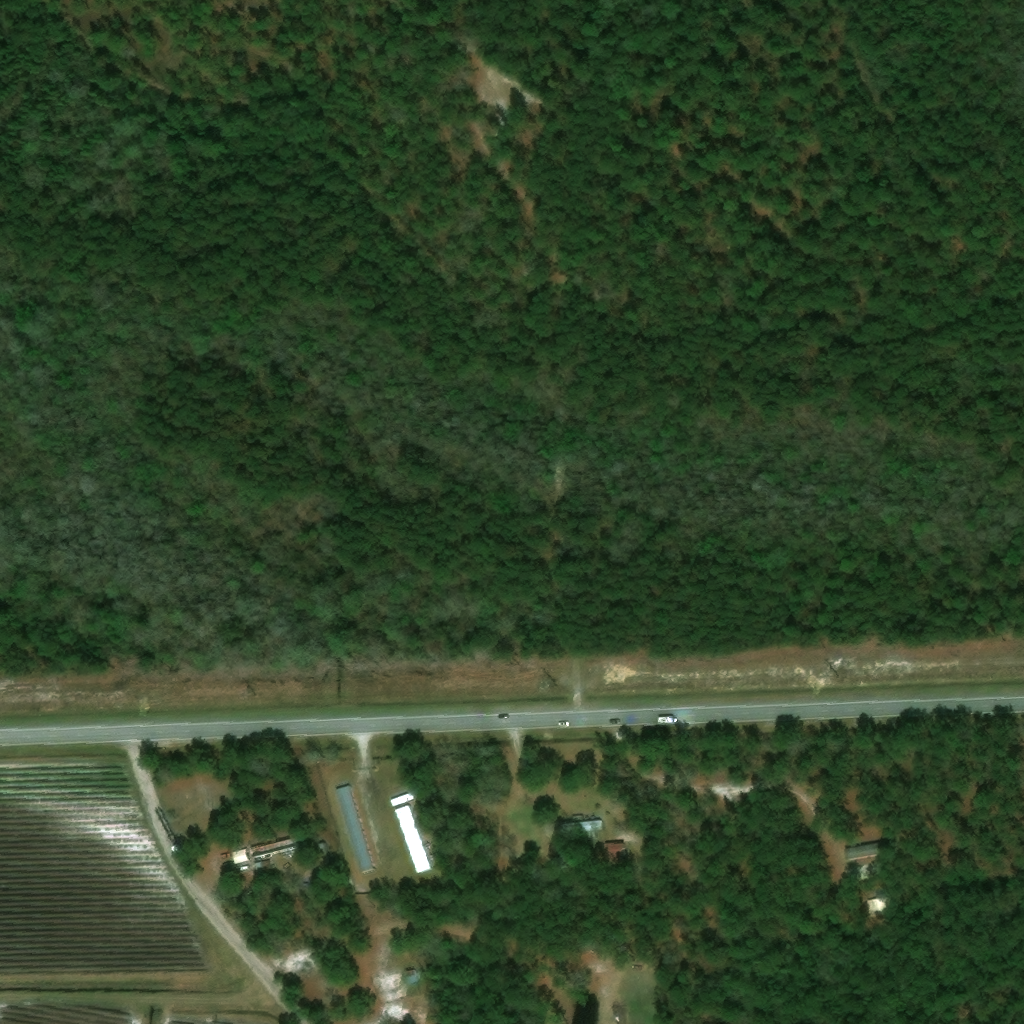

In [224]:
data.train_ds.x[5]

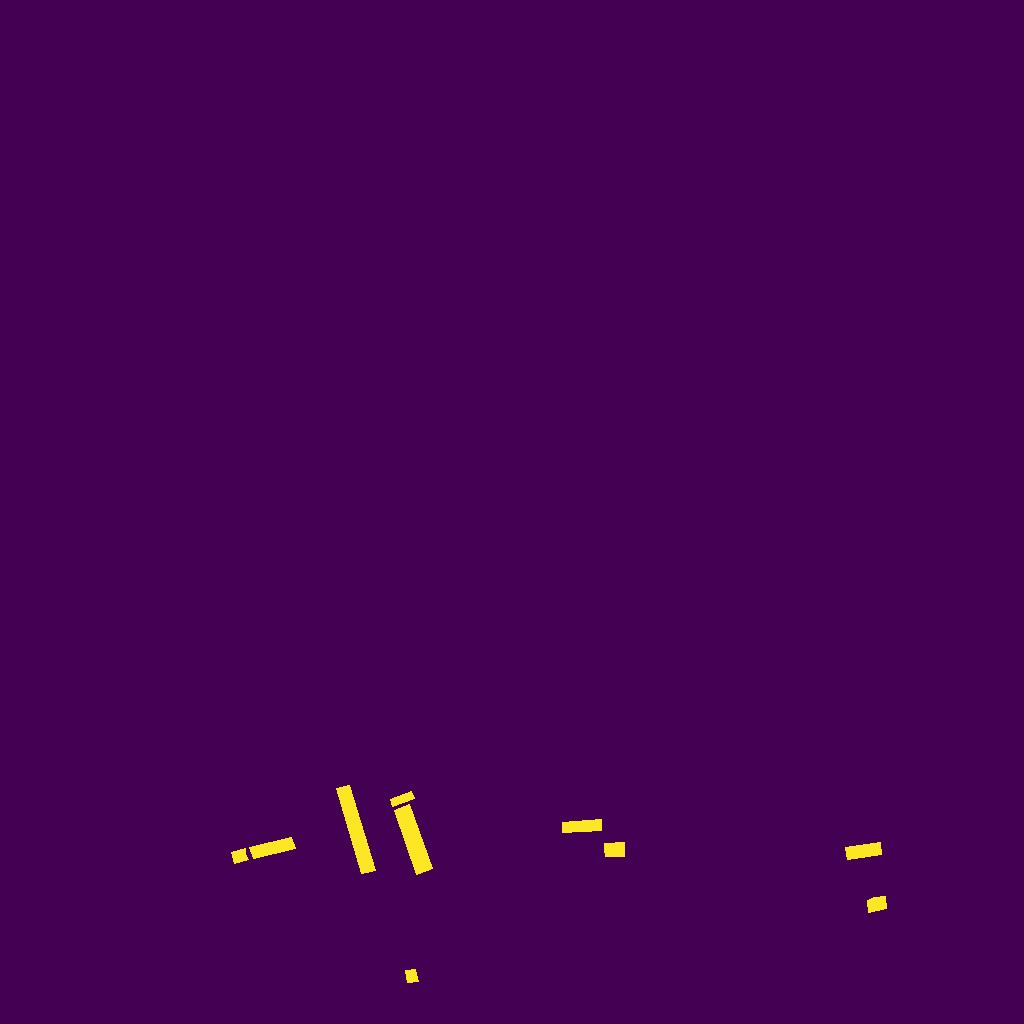

In [225]:
data.train_ds.y[5]

In [226]:
data.train_ds.x[5].data.mean(), data.train_ds.x[5].data.std()

(tensor(0.2044), tensor(0.1049))

In [227]:
data.train_ds.y[5].data.unique()

tensor([0, 1])

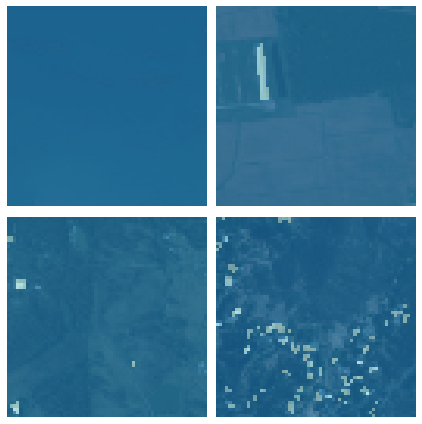

In [228]:
data.show_batch(2, figsize=(6, 6), alpha=.7)

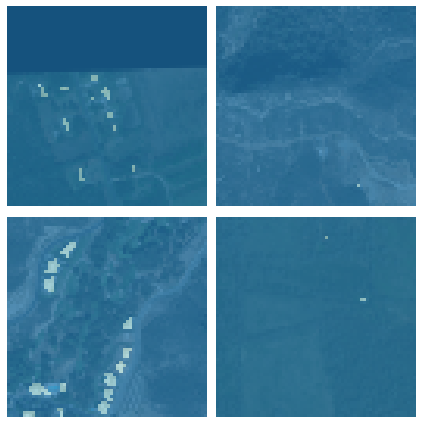

In [229]:
data.show_batch(2, figsize=(6, 6), ds_type=DatasetType.Valid, alpha=.7)

In [230]:
data.classes

array(['Empty', 'Building'], dtype='<U8')

## Normalization

In [234]:
data.train_ds.x[6].data.mean()

tensor(0.2670)

In [235]:
data.train_ds.y[6].data.unique()

tensor([0, 1])

In [236]:
xb, yb = next(iter(data.train_dl))

In [237]:
xb.min(), xb.max(), xb.mean(), xb.std()

(tensor(-1.9776), tensor(2.4741), tensor(-0.9017), tensor(0.5479))

## Custom Loss

In [238]:
#export
def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = input[:,1,None].sigmoid()
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()
    return (1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth)))

def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(pred,targ) + dice_loss(pred,targ)


In [239]:
def acc_fixed(input, targs):
    n = targs.shape[0]
    targs = targs.squeeze(1)
    targs = targs.view(n,-1)
    input = input.argmax(dim=1).view(n,-1)
    return (input==targs).float().mean()

def acc_thresh(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()


In [240]:
metrics = [dice_loss, accuracy_thresh, dice]

In [241]:
learn = unet_learner(data, models.resnet34, metrics=metrics)

In [242]:
learn.metrics

[<function __main__.dice_loss(input, target)>,
 <function fastai.metrics.accuracy_thresh(y_pred: torch.Tensor, y_true: torch.Tensor, thresh: float = 0.5, sigmoid: bool = True) -> <function NewType.<locals>.new_type at 0x116adad40>>,
 <function fastai.metrics.dice(input: torch.Tensor, targs: torch.Tensor, iou: bool = False, eps: float = 1e-08) -> <function NewType.<locals>.new_type at 0x116adad40>>]

In [243]:
learn.loss_func = combo_loss

In [244]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


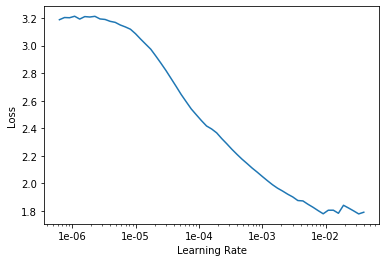

In [245]:
learn.recorder.plot()

In [246]:
lr = 1e-3

In [257]:
learn.fit_one_cycle(5, max_lr=lr)

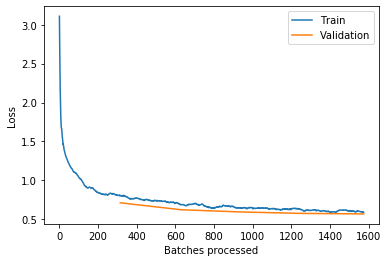

In [258]:
learn.recorder.plot_losses()

In [259]:
learn.save('sz64_stage1');

In [260]:
learn.load('sz64_stage1');

## Predict batch and look at results

In [262]:
learn.model.eval();

In [263]:
learn.model.training

False

In [372]:
learn.pred_batch??

In [264]:
outputs = learn.pred_batch(ds_type=DatasetType.Valid, )

In [265]:
outputs.shape

torch.Size([8, 2, 64, 64])

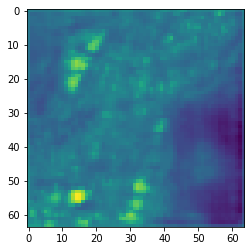

In [272]:
plt.imshow(outputs[2][1].numpy());

In [320]:
#export
def pred2mask(pred):
    return (pred[:,1,None].sigmoid() > .95).long()

torch.Size([8, 1, 64, 64])

In [323]:
predmask = pred2mask(outputs)

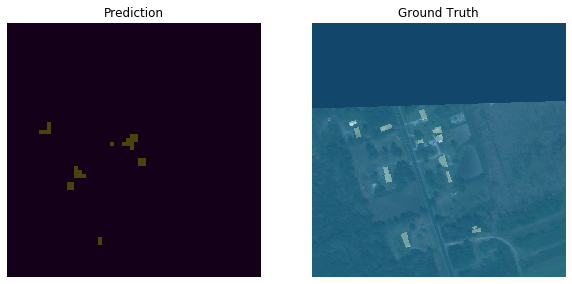

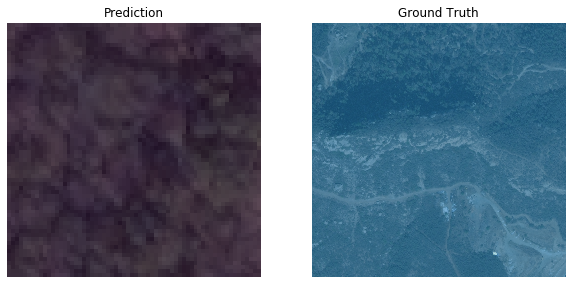

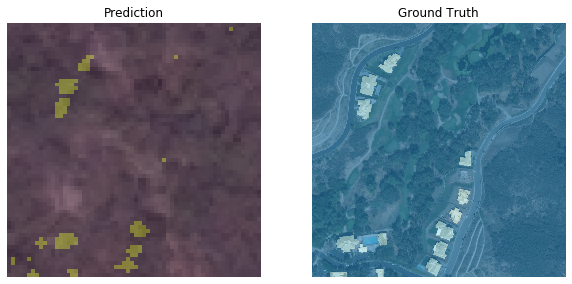

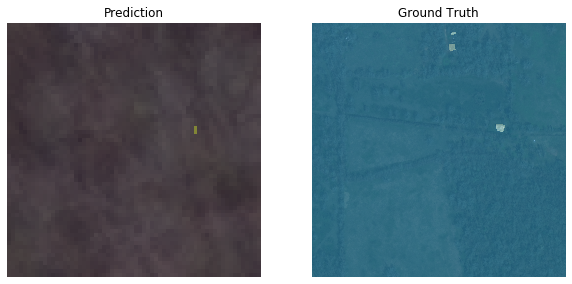

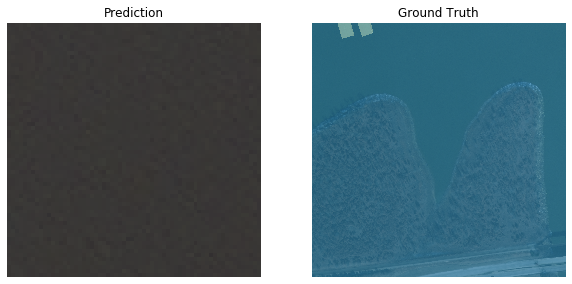

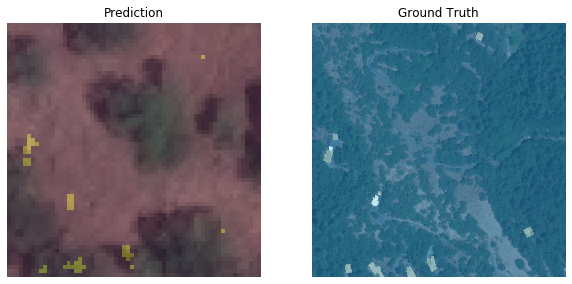

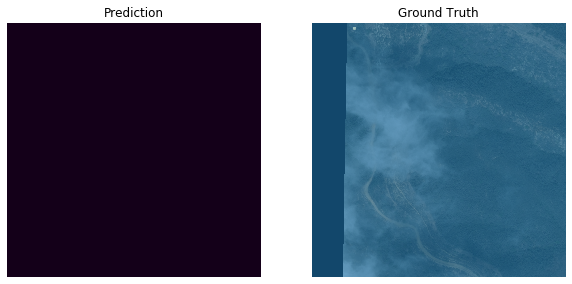

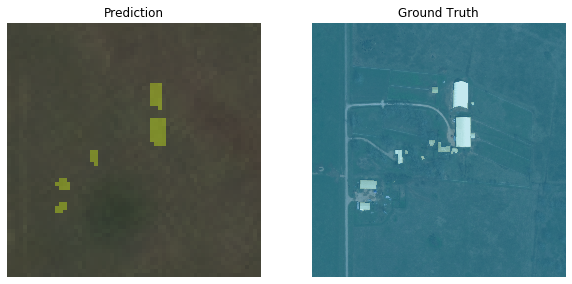

In [370]:
for i in range(bs):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    ax1.set_title('Prediction')
    data.valid_ds.x[i].show(ax=ax1)
    ax1.imshow(predmask[i,0], alpha=0.3)#, cmap=CMAP, vmin=0, vmax=4)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)

# -fin